### Jupyter notebook for quiz for lessons 2.5.5 and 2.5.6
This Jupyter notebook co-simulates an electric vehicle plus its battery pack.

First, we define the function that simulates the vehicle and returns simulation results.

In [1]:
% results = simVehicle(vehicle,cycle,grade)
%   - simulate a vehicle defined by "vehicle", perhaps created using
%     setupSimVehicle.m
%   - cycle is Nx2, where first column is time in seconds and second column
%     is desired speed in miles per hour
%   - grade is road grade in percent - either a constant grade for all
%     time, or a different grade value for every point in time
function results = simVehicle(vehicle,cycle,grade)
  rho = 1.225; % air density, kg/m3

  results.vehicle = vehicle;
  results.cycle = cycle; % time in s, desired speed in miles/hour
  results.time = cycle(:,1); % s
  if isscalar(grade),
    results.grade = repmat(atan(grade/100),size(results.time)); % rad
  else
    results.grade = atan(grade/100); % rad
  end 
  results.desSpeedKPH = cycle(:,2) * 1.609344; % convert to km/h
  results.desSpeed = min(vehicle.maxSpeed,results.desSpeedKPH*1000/3600); % m/s

  % pre-allocate storage for results
  results.desAccel = zeros(size(results.desSpeed)); % m/s2
  results.desAccelForce = zeros(size(results.desSpeed)); % N
  results.aeroForce = zeros(size(results.desSpeed)); % N
  results.rollGradeForce = zeros(size(results.desSpeed)); % N
  results.demandTorque = zeros(size(results.desSpeed)); % N-m
  results.maxTorque = zeros(size(results.desSpeed)); % N-m
  results.limitRegen = zeros(size(results.desSpeed)); % N-m
  results.limitTorque = zeros(size(results.desSpeed)); % N-m
  results.motorTorque = zeros(size(results.desSpeed)); % N-m
  results.demandPower = zeros(size(results.desSpeed)); % kW
  results.limitPower = zeros(size(results.desSpeed)); % kW
  results.batteryDemand = zeros(size(results.desSpeed)); % kW
  results.current = zeros(size(results.desSpeed)); % A
  results.batterySOC = zeros(size(results.desSpeed)); % 0..100
  results.actualAccelForce = zeros(size(results.desSpeed)); % N
  results.actualAccel = zeros(size(results.desSpeed)); % m/s2
  results.motorSpeed = zeros(size(results.desSpeed)); % RPM
  results.actualSpeed = zeros(size(results.desSpeed)); % m/s
  results.actualSpeedKPH = zeros(size(results.desSpeed)); % km/h
  results.distance = zeros(size(results.desSpeed)); % km
  
  prevSpeed = 0; prevTime = results.time(1) - 1; prevMotorSpeed = 0; 
  prevSOC = vehicle.drivetrain.pack.socFull; prevDistance = 0;
  for k = 1:length(results.desSpeed),
    results.desAccel(k) = (results.desSpeed(k) - prevSpeed)/ ...
        (results.time(k) - prevTime);
    results.desAccelForce(k) = vehicle.equivMass * results.desAccel(k);
    results.aeroForce(k) = 0.5 * rho * vehicle.Cd * vehicle.A * prevSpeed^2;
    results.rollGradeForce(k) = vehicle.maxWeight * 9.81 * sin(results.grade(k));
    if abs(prevSpeed) > 0,
      results.rollGradeForce(k) = results.rollGradeForce(k) + ...
        vehicle.drivetrain.wheel.rollCoef * vehicle.maxWeight * 9.81;
    end
    results.demandTorque(k) = (results.desAccelForce(k) + results.aeroForce(k) + ...
        results.rollGradeForce(k) + vehicle.roadForce) * ...
        vehicle.drivetrain.wheel.radius / vehicle.drivetrain.gearRatio;
    if prevMotorSpeed < vehicle.drivetrain.motor.RPMrated,
      results.maxTorque(k) = vehicle.drivetrain.motor.Lmax;
    else
      results.maxTorque(k) = vehicle.drivetrain.motor.Lmax * ...
          vehicle.drivetrain.motor.RPMrated / prevMotorSpeed;
    end
    results.limitRegen(k) = min(results.maxTorque(k),...
        vehicle.drivetrain.regenTorque  * vehicle.drivetrain.motor.Lmax);
    results.limitTorque(k) = min(results.demandTorque(k),results.maxTorque(k));
    if results.limitTorque(k) > 0,
      results.motorTorque(k) = results.limitTorque(k);
    else
      results.motorTorque(k) = max(-results.limitRegen(k),results.limitTorque(k));
    end
    
    results.actualAccelForce(k) = results.limitTorque(k) * vehicle.drivetrain.gearRatio / ...
        vehicle.drivetrain.wheel.radius - results.aeroForce(k) - results.rollGradeForce(k) - ...
        vehicle.roadForce;
    results.actualAccel(k) = results.actualAccelForce(k) / vehicle.equivMass;
    results.motorSpeed(k) = min(vehicle.drivetrain.motor.RPMmax,...
        vehicle.drivetrain.gearRatio * (prevSpeed + results.actualAccel(k) * ...
        (results.time(k) - prevTime)) * 60 / (2*pi*vehicle.drivetrain.wheel.radius));
    results.actualSpeed(k) = results.motorSpeed(k) * 2*pi*vehicle.drivetrain.wheel.radius / ...
        (60 * vehicle.drivetrain.gearRatio);
    results.actualSpeedKPH(k) = results.actualSpeed(k) * 3600/1000;
    deltadistance = (results.actualSpeed(k) + prevSpeed)/2 * (results.time(k) - prevTime)/1000;
    results.distance(k) = prevDistance + deltadistance;

    if results.limitTorque(k) > 0,
      results.demandPower(k) = results.limitTorque(k);
    else
      results.demandPower(k) = max(results.limitTorque(k),-results.limitRegen(k));
    end
    results.demandPower(k) = results.demandPower(k) * 2*pi * (prevMotorSpeed + results.motorSpeed(k))/2 / 60000;
    results.limitPower(k) = max(-vehicle.drivetrain.motor.maxPower,min(...
        vehicle.drivetrain.motor.maxPower,results.demandPower(k)));
    results.batteryDemand(k) = vehicle.overheadPwr/1000;
    if results.limitPower(k) > 0,
      results.batteryDemand(k) = results.batteryDemand(k) + ...
            results.limitPower(k)/vehicle.drivetrain.efficiency;
    else
      results.batteryDemand(k) = results.batteryDemand(k) + ...
            results.limitPower(k)*vehicle.drivetrain.efficiency;
    end
    results.current(k) = results.batteryDemand(k)*1000/vehicle.drivetrain.pack.vnom;
    results.batterySOC(k) = prevSOC - results.current(k) * (results.time(k) - prevTime) / ...
        (36*vehicle.drivetrain.pack.module.capacity);
      
    
    prevTime = results.time(k);
    prevSpeed = results.actualSpeed(k);
    prevMotorSpeed = results.motorSpeed(k);
    prevSOC = results.batterySOC(k);
    prevDistance = results.distance(k);
  end
end

Next, we define the functions that set up the inputs to the vehicle simulation and execute the simulation.

In [2]:
% setup simulation of vehicle - pass on to simVehicle.m
function results = setupSimVehicle(grade)
  % global cell module pack motor drivetrain vehicle cycle results
  addpath readonly
  files = {'nycc.txt','udds.txt','us06.txt','hwy.txt'};  

  % Setup the Chevy Volt
  % set up cell: capacity [Ah], weight [g], (vmax, vnom, vmin) [V]
  cell = setupCell(15,450,4.2,3.8,3.0);
  % set up module: numParallel, numSeries, overhead for this cell by weight
  module = setupModule(3,8,0.08,cell);
  % set up pack: numSeries, overhead by weight, (full SOC, empty SOC) [%],
  % efficiency for this module
  pack = setupPack(12,0.1,75,25,0.96,module);
  % set up motor: Lmax [Nm], (RPMrated, RPMmax) [RPM], efficiency,
  % inertia [kg/m2]
  motor = setupMotor(275,4000,12000,.95,0.2);
  % set up wheel: radius [m], inertia [kg/m2], rollCoef
  wheel = setupWheel(0.35,8,0.0111);
  % set up drivetrain: inverter efficiency, fractional regen torque limit,
  % gear ratio, gear inertia [kg/m2], gear efficiency, for this pack,
  % motor, and wheel 
  drivetrain = setupDrivetrain(0.94,0.9,12,0.05,0.97,pack,motor,wheel);
  % set up vehicle: # wheels, roadForce [N], Cd, frontal area [m2], weight
  % [kg], payload [kg], overhead power [W] for this drivetrain
  vehicle = setupVehicle(4,0,0.22,1.84,1425,75,200,drivetrain);
  
  fprintf('\n\nStarting sims...\n');
  for theCycle = 1:length(files),
    cycle = dlmread(sprintf('readonly/%s',files{theCycle}),'\t',2,0);
    results{theCycle} = simVehicle(vehicle,cycle,grade);
    range = (vehicle.drivetrain.pack.socFull - vehicle.drivetrain.pack.socEmpty) /...
      (vehicle.drivetrain.pack.socFull - results{theCycle}.batterySOC(end)) * ...
      results{theCycle}.distance(end);
    fprintf('Cycle = %s, range = %6.1f [km]\n',files{theCycle},range);
  end
end

function cell = setupCell(capacity,weight,vmax,vnom,vmin)
  cell.capacity = capacity; % ampere hours
  cell.weight = weight; % grams
  cell.vmax = vmax; % volts
  cell.vnom = vnom; % volts
  cell.vmin = vmin; % volts
  cell.energy = vnom * capacity; % Watt-hours
  cell.specificEnergy = 1000*cell.capacity*cell.vnom/cell.weight; % Wh/kg
end
  
function module = setupModule(numParallel,numSeries,overhead,cell)
  module.numParallel = numParallel;
  module.numSeries = numSeries;
  module.overhead = overhead;
  module.cell = cell;
  module.numCells = numParallel * numSeries;
  module.capacity = numParallel * cell.capacity;
  module.weight = module.numCells * cell.weight * 1/(1 - overhead)/1000; % kg
  module.energy = module.numCells * cell.energy/1000; % kWh
  module.specificEnergy = 1000 * module.energy / module.weight; % Wh/kg
end

function pack = setupPack(numSeries,overhead,socFull,socEmpty,efficiency,module)
  pack.numSeries = numSeries;
  pack.overhead = overhead;
  pack.module = module;
  pack.socFull = socFull;
  pack.socEmpty = socEmpty; % unitless
  pack.efficiency = efficiency; % unitless, captures I*I*R losses
  pack.numCells = module.numCells * numSeries;
  pack.weight = module.weight * numSeries * 1/(1 - overhead); % kg
  pack.energy = module.energy * numSeries; % kWh
  pack.specificEnergy = 1000 * pack.energy / pack.weight; % Wh/kg
  pack.vmax = numSeries*module.numSeries*module.cell.vmax;
  pack.vnom = numSeries*module.numSeries*module.cell.vnom;
  pack.vmin = numSeries*module.numSeries*module.cell.vmin;
end

function motor = setupMotor(Lmax,RPMrated,RPMmax,efficiency,inertia)
  motor.Lmax = Lmax; % N-m
  motor.RPMrated = RPMrated;
  motor.RPMmax = RPMmax;
  motor.efficiency = efficiency;
  motor.inertia = inertia; %kg-m2
  motor.maxPower = 2*pi*Lmax*RPMrated/60000; % kW
end
  
function wheel = setupWheel(radius,inertia,rollCoef)
  wheel.radius = radius; % m
  wheel.inertia = inertia; % km-m2
  wheel.rollCoef = rollCoef;
end

function drivetrain = setupDrivetrain(inverterEfficiency,regenTorque,...
      gearRatio,gearInertia,gearEfficiency,pack,motor,wheel)
  drivetrain.inverterEfficiency = inverterEfficiency;
  drivetrain.regenTorque = regenTorque; % fraction of total torque available
  drivetrain.pack = pack;
  drivetrain.motor = motor;
  drivetrain.wheel = wheel;
  drivetrain.gearRatio = gearRatio;
  drivetrain.gearInertia = gearInertia; % km-m2, measured on motor side
  drivetrain.gearEfficiency = gearEfficiency;
  drivetrain.efficiency = pack.efficiency * inverterEfficiency * ...
                          motor.efficiency * gearEfficiency;
end

function vehicle = setupVehicle(wheels,roadForce,Cd,A,weight,payload,overheadPwr,drivetrain)
  vehicle.drivetrain = drivetrain;
  vehicle.wheels = wheels; % number of them
  vehicle.roadForce = roadForce; % N
  vehicle.Cd = Cd; % drag coeff
  vehicle.A = A; % frontal area, m2
  vehicle.weight = weight; % kg
  vehicle.payload = payload; % kg
  vehicle.overheadPwr = overheadPwr; % W
  vehicle.curbWeight = weight + drivetrain.pack.weight;
  vehicle.maxWeight = vehicle.curbWeight + payload;
  vehicle.rotWeight = ((drivetrain.motor.inertia + drivetrain.gearInertia) * ...
      drivetrain.gearRatio^2 + drivetrain.wheel.inertia*wheels)/drivetrain.wheel.radius^2;
  vehicle.equivMass = vehicle.maxWeight + vehicle.rotWeight;
  vehicle.maxSpeed = 2 * pi * drivetrain.wheel.radius * ...
      drivetrain.motor.RPMmax * 60 / (1000 * drivetrain.gearRatio); % km/h
end

Below, see an example of invoking the simulator. **Be sure to put a semicolon at the end of the line** to suppress output of the "results" variable! It holds an enormous amount of data and will probably crash your browser if you attempt to display it all.

The simulator also displays the vehicle range for the four different drive cycles that I have supplied.

In [3]:
results = setupSimVehicle(0);



Starting sims...
Cycle = nycc.txt, range =   57.0 [km]
Cycle = udds.txt, range =   70.9 [km]
Cycle = us06.txt, range =   51.0 [km]
Cycle = hwy.txt, range =   72.2 [km]


If you want to investigate the data stored in the "results" variable, you can first ask Octave to show you the names of the fields. Note that there is one set of results data per drive-cycle scenario.

In [4]:
fieldnames(results{1})

ans = 
{
  [1,1] = vehicle
  [2,1] = cycle
  [3,1] = time
  [4,1] = grade
  [5,1] = desSpeedKPH
  [6,1] = desSpeed
  [7,1] = desAccel
  [8,1] = desAccelForce
  [9,1] = aeroForce
  [10,1] = rollGradeForce
  [11,1] = demandTorque
  [12,1] = maxTorque
  [13,1] = limitRegen
  [14,1] = limitTorque
  [15,1] = motorTorque
  [16,1] = demandPower
  [17,1] = limitPower
  [18,1] = batteryDemand
  [19,1] = current
  [20,1] = batterySOC
  [21,1] = actualAccelForce
  [22,1] = actualAccel
  [23,1] = motorSpeed
  [24,1] = actualSpeed
  [25,1] = actualSpeedKPH
  [26,1] = distance
}


You can see the parameter values used as input to the simulation, such as:

In [5]:
results{1}.vehicle

ans =

  scalar structure containing the fields:

    drivetrain =

      scalar structure containing the fields:

        inverterEfficiency =  0.94000
        regenTorque =  0.90000
        pack =

          scalar structure containing the fields:

            numSeries: 1x1 scalar
            overhead: 1x1 scalar
            module: 1x1 scalar struct
            socFull: 1x1 scalar
            socEmpty: 1x1 scalar
            efficiency: 1x1 scalar
            numCells: 1x1 scalar
            weight: 1x1 scalar
            energy: 1x1 scalar
            specificEnergy: 1x1 scalar
            vmax: 1x1 scalar
            vnom: 1x1 scalar
            vmin: 1x1 scalar

        motor =

          scalar structure containing the fields:

            Lmax: 1x1 scalar
            RPMrated: 1x1 scalar
            RPMmax: 1x1 scalar
            efficiency: 1x1 scalar
            inertia: 1x1 scalar
            maxPower: 1x1 scalar

        wheel =

          scalar structure containing the f

You can plot some outputs of interest from the simulation, such as:


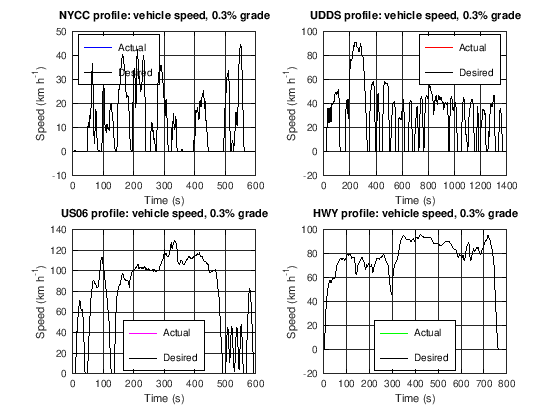

In [6]:
%% Plot the desired and actual vehicle speed profiles
names = {'NYCC','UDDS','US06','HWY'};
style = {'b','r','m','g'};
locations = {'northwest','northeast','south','south'};
for ii = 1:length(results)
  plotData = results{ii}.actualSpeedKPH;
  subplot(2,2,ii); plot(0:length(plotData)-1,plotData,style{ii});
  plotData = results{ii}.desSpeedKPH; hold on; grid on;
  plot(0:length(plotData)-1,plotData,'k');
  title(sprintf('%s profile: vehicle speed, 0.3%% grade',names{ii}));
  xlabel('Time (s)'); ylabel('Speed (km h^{-1})');
  legend('Actual','Desired','location',locations{ii});
end

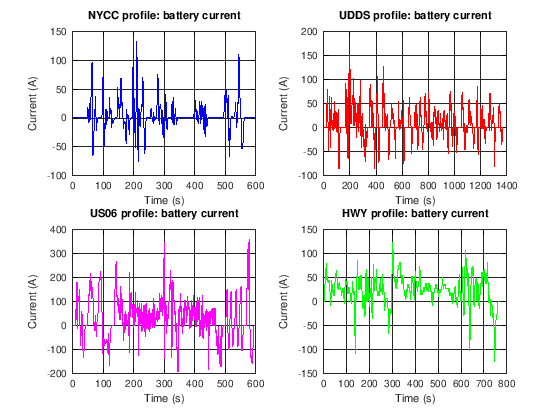

In [7]:
%% Plot the Battery Pack Current Profiles
for ii = 1:length(results),
  plotData = results{ii}.current;
  subplot(2,2,ii); plot(0:length(plotData)-1,plotData,style{ii}); 
  title(sprintf('%s profile: battery current',names{ii})); 
  xlabel('Time (s)'); ylabel('Current (A)'); grid on;
end

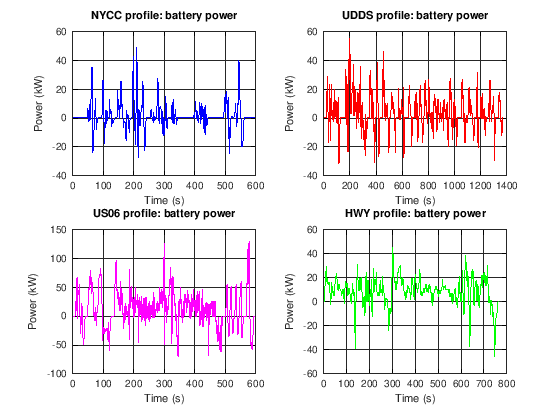

In [8]:
%% Plot the Battery Pack Demanded Power Profile
for ii = 1:length(results),
  plotData = results{ii}.batteryDemand;
  subplot(2,2,ii); plot(0:length(plotData)-1,plotData,style{ii}); 
  title(sprintf('%s profile: battery power',names{ii})); 
  xlabel('Time (s)'); ylabel('Power (kW)'); grid on;
end

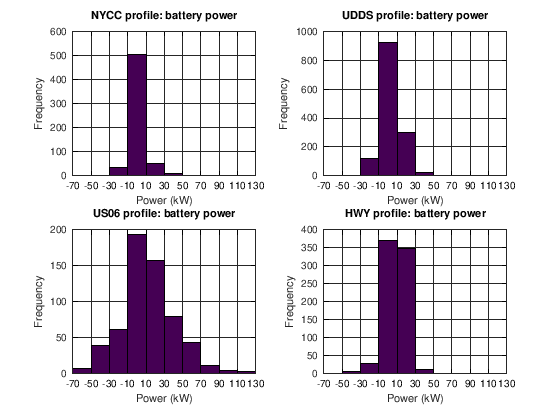

In [9]:
%% Plot Histograms of Battery Pack Demanded Power
edges = -70:20:140;
for ii = 1:length(results),
  [N,Bin] = histc(results{ii}.batteryDemand,edges);
  subplot(2,2,ii); bar(edges,N,'histc'); xlim([min(edges) max(edges)]);
  title(sprintf('%s profile: battery power',names{ii}));
  ylabel('Frequency'); xlabel('Power (kW)'); grid on;
end

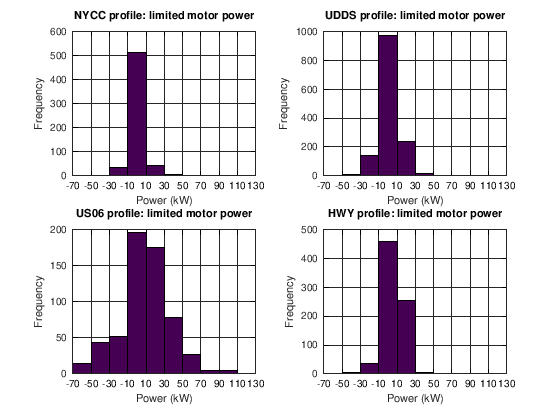

In [10]:
%% Plot Histograms of Motor Demanded Power
for ii = 1:length(results)
  [N,Bin] = histc(results{ii}.limitPower,edges);
  subplot(2,2,ii); bar(edges,N,'histc'); xlim([min(edges) max(edges)]);
  title(sprintf('%s profile: limited motor power',names{ii}));
  ylabel('Frequency'); xlabel('Power (kW)'); grid on;
end

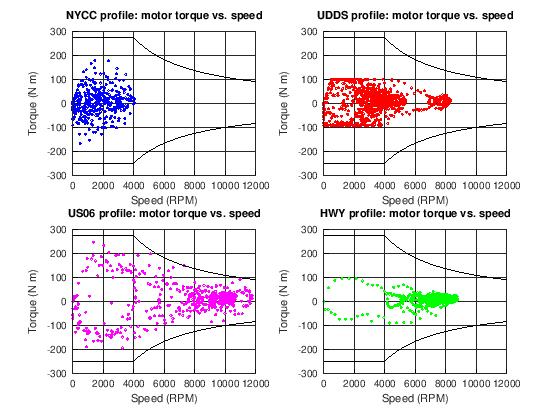

In [11]:
%% Plot Scatter Plot of Motor Torque Vs. RPM
motor = results{1}.vehicle.drivetrain.motor;
regen = results{1}.vehicle.drivetrain.regenTorque;
RPM = motor.RPMrated:50:motor.RPMmax;
TRQ = motor.Lmax*motor.RPMrated./RPM;
for ii = 1:length(results),
  subplot(2,2,ii);
  scatter(results{ii}.motorSpeed,results{ii}.limitTorque,style{ii});
  title(sprintf('%s profile: motor torque vs. speed',names{ii}));
  xlim([0 12000]); ylim([-300 300]); hold on; grid on;
  xlabel('Speed (RPM)'); ylabel('Torque (N m)');
  plot([0 motor.RPMrated],motor.Lmax*[1 1],'k');
  plot([0 motor.RPMrated],-regen*motor.Lmax*[1 1],'k');
  plot(RPM,TRQ,'k'); plot(RPM,-regen*TRQ,'k');
end